# Database 4

### 인증된 사용자에 대한 접근 제한하기

<b>개요</b>  

is_authenticated와 View decorator를 활용하여 코드 정리하기  


<b>인증된 사용자인 경우만 댓글 작성 및 삭제하기</b>

```python

# articles/views.py

@require_POST
def comments_create(request, pk):
    if request.user.is_authenticated:
        article = Article.objects.get(pk=pk)
        comment_form = CommentForm(request.POST)
        if comment_form.is_valid():
            comment = comment_form.save(commit=False)
            comment.article = article
            comment.user = request.user
            comment.save()
        return redirect('articles:detail', article.pk)
    
    return redirect('accounts:login')
```

&nbsp;

```py
@require_POST
def comments_delete(request, pk, comment_pk):
    if request.user.is_authenticated:
        comment = Comment.objects.get(pk=comment_pk)
        if request.user == comment.user:
            comment.delete()
    return redirect('articles:detail', pk)
```

<b>비인증 사용자는 CommentForm을 볼 수 없도록 하기</b>  

```html
<!-- articles/templates/articles/detail.html -->

...
    {% if request.user.is_authenticated %}
      <form action="{% url 'articles:comments_create' article.pk %}" method="POST">
        {% csrf_token %}
        {{comment_form}}
        <input type="submit" value="저장">
      </form>
    {% else %}
      <a href="{% url 'accounts:login' %}">[댓글을 작성하려면 로그인하세요.]</a>
    {% endif %}

...

```

### Many to may relationship

<b>RDB에서의 관계 복습</b>  

<mark>M:N</mark>  

Many-to-many relationships

한 테이블의 0개 이상의 레코드가 다른 테이브르이 0개 이상의 레코드와 관련된 경우  

양쪽 모두에서 N:1 관계를 가짐  

### Intro

<b>개요</b>  

의사와 환자의 관계(M:N)  

&nbsp;

<b>[참고] 데이터 모델링</b>  

주어진 개념으로부터 논리적인 데이터 모델을 구성하는 작업  

물리적인 데이터베이스 모델로 만들어 고객의 요구에 따라 특정 정보 시스템 데이터베이스에 반영하는 작업  

&nbsp;

<b>시작하기 전 용어 정리</b>  

target model
- 관계 필드를 가지지 않은 모델  

source model  
- 관계 필드를 가진 모델  


<b>N:1의 한계</b>  

의사와 환자간 예약 시스템을 구현  

지금까지 배운 N:1 관계를 생각해 한 명의 의사에게 여러 환자가 예약할 수 있다고 모델 관계를 설정  

```py
# hospital/models.py

from django.db import models

# Create your models here.
class Doctor(models.Model):
    name = models.TextField()

    def __str__(self):
        return f"{self.name} 전문의"
    

class Patient(models.Model):
    doctor = models.ForeignKey(Doctor, on_delete=models.CASCADE)
    name = models.TextField()

    def __str__(self):
        return f"{self.pk}번 환자 {self.name}"
```

&nbsp;

migration 진행 및 shell_plus 실행

```bash
$python manage.py makemigrations
$python manage.py migrate

# django_extensions를 settings의 installed app에 지정할 것
$python manage.py shell_plus
```

&nbsp;

각각의 2명의 의사와 환자를 생성하고 환자는 서로 다른 의사에게 예약을 했다고 가정  

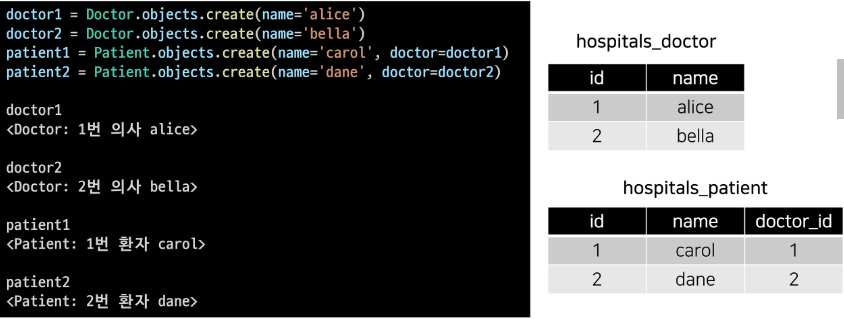

1번 환자(carol)가 두 의사 모두에게 방문하려고 함  

```py
patient3 = Patient.objects.create(name='carol', doctor=doctor2)
```

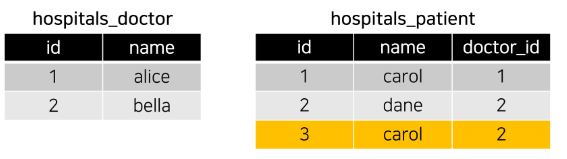

동시에 예약할 수는 없을까?  

```py
patient4 = Patient.objects.crate(name='carol' doctor= doctor1, doctor2)
```
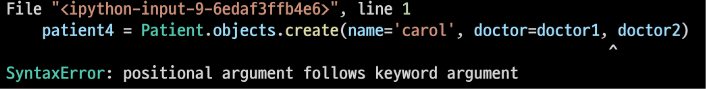

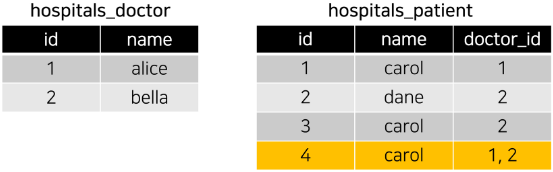

동일한 환자지만 다른 의사에게 예약하기 위해서는 객체를 하나 더 만들어서 예약을 진행해야 함  
- 새로운 환자 객체를 생성할 수 밖에 없음  

외래 키 컬럼에 '1, 2' 형태로 참조하는 것은 Integer 타입이 아니기 때문에 불가능  

그렇다면 "예약 테이블을 따로 만들자!"

<b>중개 모델</b>  

환자 모델은 외래키를 삭제하고 별도의 예약 모델을 새로 작성  

예약 모델은 의사와 환자에 각각 N:1 관계를 가짐  

```py
# hospitals/models.py

class Patient(models.Model):
    name = models.TextField()
    # doctor = models.ForeignKey(Doctor, on_delete=models.CASCADE)

    def __str__(self):
        return f"{self.pk}번 환자 {self.name}"


class Reservation(models.Model):
    doctor = models.ForeignKey(Doctor, on_delete=models.CASCADE)
    patient = models.ForeignKey(Patient, on_delete=models.CASCADE)

    def __str__(self):
        return f"{self.doctor_id}번 의사의 {self.patient_id}번 환자"
```

데이터베이스 초기화 후 Migration 진행 및 shell_plus 실행  
1. migratoin 파일 삭제  
2. 데이터베이스 파일 삭제  

```bash
$python manage.py makemigrations
$python manage.py migrate

$python manage.py shell_plus
```

&nbsp;

의사와 환자 생성 후 예약 만들기

```bash
$doctor1 = Doctor.objects.create(name='alice')
$patient1 = Patient.objects.create(name='carol')

$Reservation.object.create(doctor=doctor1, patient=patient1)
```

&nbsp;

에약 정보 조회  

```bash
# 의사 -> 예약 정보 찾기  
$doctor1.reservation_set.all()

# 환자 -> 예약 정보 찾기
$patient.reservation_set.all()
```

<b>Django ManyToManyField</b>  

환자 모델에 Django ManyToManyField 작성

```py
# hospital/models.py
class Patient(models.Model):
    doctors = models.ManyToManyField(Doctor)
    name = models.TextField()

    def __str__(self):
        return f"{self.pk}번 환자 {self.name}"

# Reservation Class 주석 처리
```

&nbsp;

데이터베이스 초기화 후 Migration 진행 및 shell_plus 실행  
1. migratoin 파일 삭제  
2. 데이터베이스 파일 삭제  

```bash
$python manage.py makemigrations
$python manage.py migrate

$python manage.py shell_plus
```

&nbsp;

생성된 중개 테이블 hosptals_patient_doctors 확인  

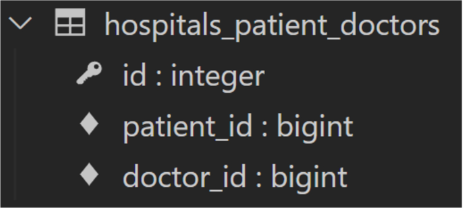

&nbsp;

의사 1명과 환자 2명 생성

```bash
$doctor1 = Doctor.objects.create(name='alice')
$patient1 = Patient.objects.create(name='carol')
$patient2 = Patient.objects.create(name='dane')
```

&nbsp;

에약 생성 (환자가 의사에게 예약)  

```bash
# patient1이 doctor1에게 예약  
$patient1.doctors.add(doctor1)
```

```bash
# patient1 - 자신이 예약한 의사목록 확인
$patient1.doctors.all()
```

```bash
# doctor1 - 자신의 예약된 환자목록 확인
$doctor.patient_set.all()
```

&nbsp;

에약 생성(의사가 환자를 예약)  

```bash
# doctor1이 patient2를 예약
$doctor1.patient_set.add(patient2)
```

```bash
# doctor1 - 자신의 예약 환자목록 확인  
doctor1.patient_set.all()
```

```bash
# patient1, 2 - 자신이 예약한 의사목록 확인  

$patient1.doctors.all()
$patient2.doctors.all()
```

예약 취소하기(삭제)

기존에는 해당하는 Reservation을 찾아 지워야 했다면, 이제는 ```.remove()``` 사용

```bash
# doctor1이 patient1 진료 예약 취소  

$doctor1.patient_set.remove(patient1)
$doctor1.patient_set.all()
$patient1.doctors.all()
```

```bash
# patient2가 doctor1 진료 예약 취소  

$patient2.doctors.remove(doctor1)
$patient2.doctors.all()
$doctor1.patient_set.all()
``` 

Django는 ManyToManyField를 통해 중개 테이블을 자동으로 생성  

<b>'related_name' argument</b>  

target model이 source model을 참조할 때 사용할 manager name  

ForeginKey()의 related_name과 동일  

```py
class Patient(models.Model):
    doctors = models.ManyToManyField(Doctor, related_name='patients')
    name = models.TextField()

    def __str__(self):
        return f"{self.pk}번 환자 {self.name}"
```

Migration 진행 및 shell_plus 실행  

related_name 설정 값 확인하기  

```bash
# 1번 의사 조회하기
$doctors=Doctor.objects.get(pk=1)

# 에러 발생(relate_name을 설정하면 기존 _set manger는 사용할 수 없음)
$doctor1.patient_set.all()
```

```bash
# 변경 후
doctor1.patients.all()
```

<b>'through' argument</b>  

그렇다면 중개 모델을 직접 작성하는 경우는 없을까?  
- 중개 테이블을 수동으로 지정하려는 경우 <mark>through</mark>옵션을 사용하여 사용하려는 중개 테이블을 나타내는 Django 모델을 지정할 수 있음

가장 일반적인 용도는 <mark>중개테이블에 추가 데이터를 사용</mark>해 다대다 관계와 연결하려는 경우  

&nbsp;

through 설정 및 Reservation Class 설정  
- 이제는 예약 정보에 증상과 예약일이라는 추가 데이터가 생김  

```py
class Patient(models.Model):
    doctors = models.ManyToManyField(Doctor, through='Reservation')
    name = models.TextField()

    def __str__(self):
        return f"{self.pk}번 환자 {self.name}"


class Reservation(models.Model):
    doctor = models.ForeignKey(Doctor, on_delete=models.CASCADE)
    patient = models.ForeignKey(Patient, on_delete=models.CASCADE)
    
    symptom = models.TextField()
    reserved_at = models.DateTimeField(auto_now_add=True)

    def __str__(self):
        return f"{self.doctor.pk}번 의사의 {self.patient.pk}번 환자 "
```

데이터 베이스 초기화 후 Migration 진행 및 shell_plus 실행  

&nbsp;

의사 1명과 환자 2명 생성  

```bash
$doctor1 = Doctor.objects.create(name='alice')
$patient1 = Patient.objects.create(name='carol')
$patient2 = Patient.objects.create(name='dane')
```

예약 생성 1
```bash
# 1. Reservation class를 통한 예약 생성  

$reservation1 = Reservation(doctor=doctor1, patient=patient1, symptom='headache')
$reservation1.save()

$doctor1.patient_set.all()
$patient1.doctors.all()
```

```bash
# 2. Patient 객체를 통한 예약 생성  
$patient2.doctors.add(doctor1, through_default={'symptom':'flu'})

$doctor1.patient_set.all()
$patient2.doctors.all()
```

&nbsp;

예약 삭제  

```bash
$doctor1.patient_set.remove(patient1)
$patient2.doctors.remove(doctor1)
```

<b>정리</b>  

M:N 관계로 맺어진 두 테이블에는 변화가 없음  

Django ManyToManyField은 중개 테이블을 자동으로 생성함  

Django의 ManyToManyField는 M:N 관계를 맺는 두 모델 어디에 위치해도 상관없음  
- 대신 필드 작성 위치에 따라 참조와 역참조 방향을 주의할 것  

N:1은 완전한 종속 관계였지만 M:N은 의사에게 진찰받 환자,  
환자를 진찰하는 의사의 두 가지 형태로 모두 표현이 가능한 것  

# ManyToManyField

<b>ManyToManyField란</b>  

```ManyToManyField(to, **options)```

다대다 (M:N, many-to-many) 관계 설정 시 사용하는 모델 필드  

하나의 필수 위치인자(M:N 관계로 설정할 모델 클래스)가 필요  

모델 필드의 RelatedManager를 사용하여 관련 개체를 추가, 제거 또는 만들 수 있음  

```add(), remove(), create(), clear() ...```

&nbsp;

<b>데이터베이스에서의 표현</b>  

Django는 다대다 관계를 나타내는 중개 테이블을 만듦  

테이블 이름은 ManyToManyField 이름과 이를 포함하는 모델의 테이블 이름을 조합하여 생성됨  

```'db_table'``` argumens를 사용하여 중개 테이블의 이름을 변경할 수도 있음  

<b>ManyToManyField's Arguments</b>  

1. related_name
2. through
3. symmetrical


<h4>1. related_name</h4>

target model이 source model을 참조할 때 사용할 mange name
ForeignKey의 related_name과 동일  

<h4>2. through</h4>  

중개 테이블을 직접 작성하는 경우, through 옵션을 사용하여  
중개 테이블을 나타내는 Django 모델을 지정  

일반적으로 중개 테이블에 추가 데이터를 사용하는 다대다 관계와 연결하려는  
경우 (extra data with a many-to-many relationship)에 사용됨  

<h4>3. symmetrical</h4>  

기본 값: True  

ManyToManyField가 동일한 모델(on self)을 가리키는 정의에서만 사용  

```py
# 예시

class Person(models.Model):
    frields = Models.ManyToManyField('self')
    # friends = models.ManyToManyField('self', symmetrical=False)
```

True일 경우  
- _set 매니저를 추가하지 않음  
- source 모델의 인스턴스가 target 모델의 인스턴스르 참조하면 자동으로 target 모델 인스턴스도 source 모델 인스턴스를 자동으로 참조하도록 함(대칭)  
- 즉, 내가 당신의 친구라면 당신도 내 친구가 됨  


대칭을 원하지 않는 경우 False로 설정  
- Follow 기능 구현에서 다시 확인할 예정

<b>Related Manager</b>  

N:1 혹은 M:N 관계에서 사용 가능한 문맥(context)  

Django는 모델 간 N:1 혹은 M:N 관계가 설정되며 역참조시에 사용할 수 있는 manger를 생성  
- 우리가 이전에 모델 생성 시 objects라는 매니저를 통해 query api를 사용했던 것처럼 related manager를 통해 queryset api를 사용할 수 있게 됨  

같은 이름의 메서드여도 각 관계(N:1, M:N)에 따라 사용 및 동작됨  
- N:1에서는 target 모델 객체만 사용 가능  
- <mark>M:N 관계에서는 관련된 두 객체에서 모두 사용 가능</mark>  

메서드 종류
- <mark>add(), remove()</mark>, create(), clear, set() 등 ...

<b>methods</b> <font color='red'>many-to-many relationships 일 때의 동작만 작성되어 있음</font>  

add()
- "지정된 객체를 관련 객체 집합에 추가"
- 이미 존재하는 관계에 사용하면 관계가 복제되지 않음  
- 모델 인스턴스, 필드 값(PK)을 인자로 허용  

remove()
- "관련 객체 집합에서 지정된 모델 개체를 제거"  
- 내부적으로 QuerySet.delete()를 사용하여 관계가 삭제됨  
- 모델 인스턴스, 필드 값(PK)을 인자로 허용  

<b>중개 테이블 필드 생성 규칙</b>  

1. 소스(source model) 및 대상(target model) 모델이 다른 경우  
- id
- <containing_model>_id
- <other_model>_id

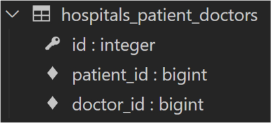

2. ManyToManyField가 동일한 모델을 가리키는 경우  
- id
- form_\<model\>_id
- to_\<model\>_id

### M:N (Article-User) 

<b>개요</b>  

Article과 User의 M:N 관계 설정을 통한 좋아요 기능 구현하기  

### LIKE

<b>모델 관계 설정</b>  

ManyToManyField 작성  

```py
# articles/models.py

class Article(models.Model):
    user = models.ForeignKey(settings.AUTH_USER_MODEL, on_delete=models.CASCADE)
    like_users = models.ManyToManyField(settings.AUTH_USER_MODEL)
    title = models.CharField(max_length=30)
    content = models.TextField()
    image = models.ImageField(blank=True, null=True)
    created_at = models.DateTimeField(auto_now_add=True)
    updated_at = models.DateTimeField(auto_now=True)
```

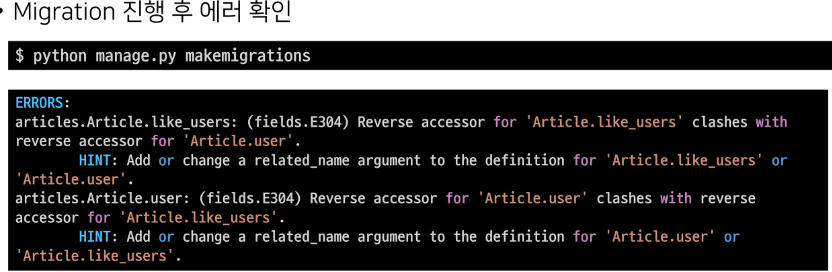

&nbsp;

like_users 필드 생성 시 자동으로 역참조에는 .articles_set 매니저가 생성됨  

그러나 이전 N:1(Artcle-User) 관계에서 이미 해당 매니저를 사용 중  
- user.article_set.all() -> 해당 유자가 작성한 모든 게시글 조회  
- user가 작성한 글들(user.article_set)과 user가 좋아요를 누른 글 (user.article_set)을 구분할 수 없게 됨  

user와 관계된 ForeginKey 혹은 ManyToManyField 중 하나에 related_name을 작성해야 함  


ManyToManyField에서 related_name 작성 후 Migration

```py
# articles/models.py

class Article(models.Model):
    user = models.ForeignKey(settings.AUTH_USER_MODEL, on_delete=models.CASCADE)
    like_users = models.ManyToManyField(settings.AUTH_USER_MODEL, related_name='like_articles')
    title = models.CharField(max_length=30)
    content = models.TextField()
    image = models.ImageField(blank=True, null=True)
    created_at = models.DateTimeField(auto_now_add=True)
    updated_at = models.DateTimeField(auto_now=True)
```

생성된 중개 테이블 확인  
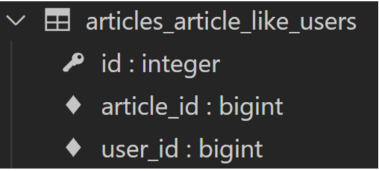

&nbsp;

User-Article간 사용 가능한 related manger 정리  

- article.user
    - 게시글 작성한 유저 - N:1

- users.aritcle_set
    - 유저가 작성하 게시글 (역참조) - N:1

- article.like_users
    - 게시글 좋아요한 유저 - M:N

- user.like_articles
    - 유저가 좋아요한 게시글(역참조) - M:N

<b>LIKE 구현</b>  

```py
# articles/urls.py

urlpatterns = [
    ...
    path('<int:article_pk>/likes/', views.likes, name='likes'),
]
```

```py
# articles/views.py

def likes(request, article_pk):
    article = Article.objects.get(pk=article_pk)

    if article.like_users.filter(pk=request.user.pk).exists():
        article.like_users.remove(request.user)
    else:
        article.like_users.add(request.user)
    return redirect('articles:index')
```

&nbsp;

<b>.exists()</b>  

QuerySet에 결과가 포함되어 있으면 True를 반환하고 그렇지 않으면 False를 반환  

특히 큰 QuerySet에 있는 특정 개체의 존재와 관련된 검색에 유용  

&nbsp;

index 템플릿에서 각 게스글에 좋아요 버튼 출력하기

```html
<!-- articles/templates/articles/index.html -->

...
    <div>
      <form action="{% url 'articles:likes' article.pk %}" method="POST">
        {% csrf_token %}
        {% if request.user in article.like_users.all %}
          <input type="submit" value="좋아요 취소">
        {% else %}
          <input type="submit" value="좋아요">
        {% endif %}
      </form>
    </div>
...
```

[번외]

```html
<span>좋아요: {{ articles.like_users.count }}개</span>
```

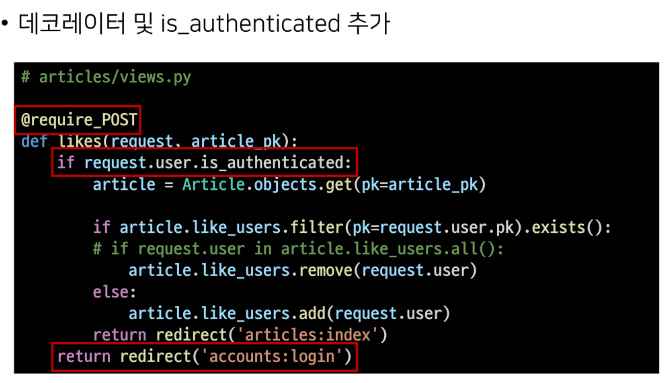